Device: cuda
Dados carregados:
Train: 54000 samples
Val:   6000 samples
Test:  10000 samples


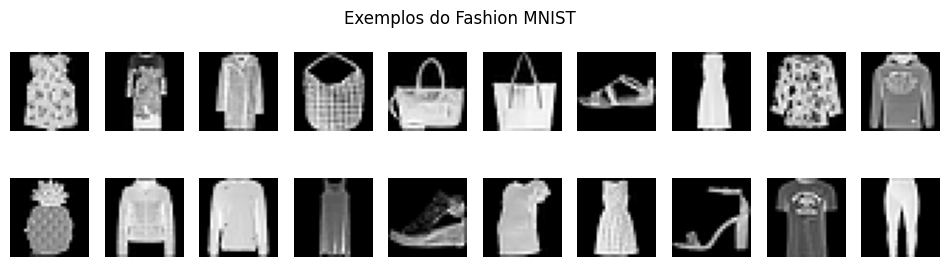

Treinando AE...
Epoch 1/10 AE: train_loss=0.097, val_loss=0.067
Epoch 2/10 AE: train_loss=0.063, val_loss=0.061
Epoch 3/10 AE: train_loss=0.058, val_loss=0.058
Epoch 4/10 AE: train_loss=0.056, val_loss=0.056
Epoch 5/10 AE: train_loss=0.055, val_loss=0.055
Epoch 6/10 AE: train_loss=0.053, val_loss=0.054
Epoch 7/10 AE: train_loss=0.053, val_loss=0.054
Epoch 8/10 AE: train_loss=0.052, val_loss=0.053
Epoch 9/10 AE: train_loss=0.051, val_loss=0.053
Epoch 10/10 AE: train_loss=0.051, val_loss=0.052
Treinamento do AE concluído!

Treinando DAE...
Epoch 1/10 DAE: train_loss=0.100, val_loss=0.068
Epoch 2/10 DAE: train_loss=0.065, val_loss=0.062
Epoch 3/10 DAE: train_loss=0.060, val_loss=0.059
Epoch 4/10 DAE: train_loss=0.058, val_loss=0.057
Epoch 5/10 DAE: train_loss=0.057, val_loss=0.056
Epoch 6/10 DAE: train_loss=0.056, val_loss=0.056
Epoch 7/10 DAE: train_loss=0.055, val_loss=0.055
Epoch 8/10 DAE: train_loss=0.054, val_loss=0.054
Epoch 9/10 DAE: train_loss=0.054, val_loss=0.054
Epoch 10/10 DAE

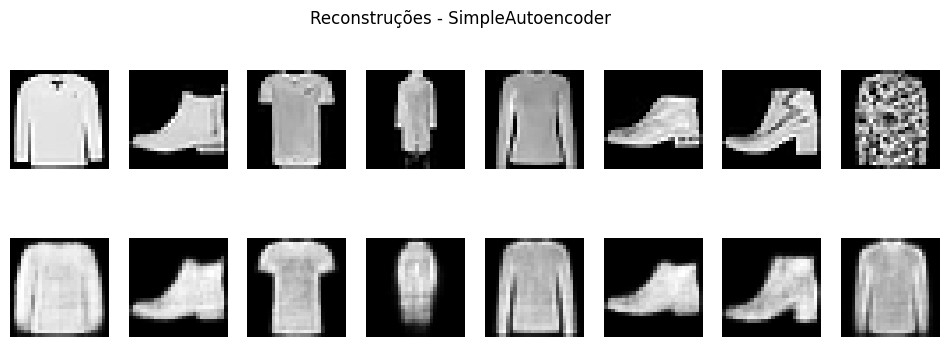

Reconstruções do DAE (entrada limpa):


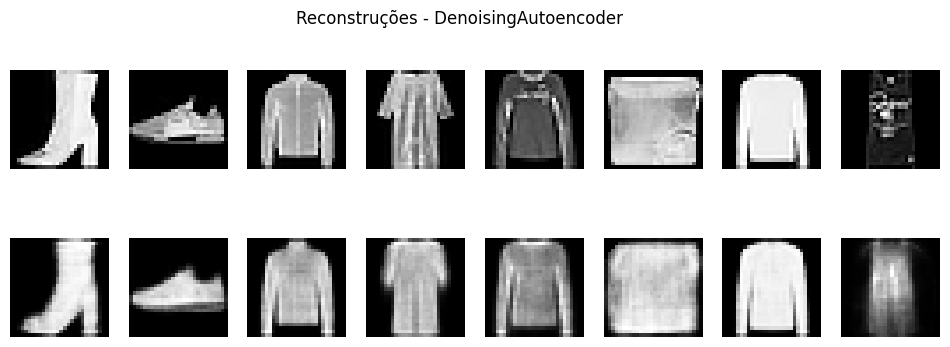

Reconstruções do DAE (entrada ruidosa):


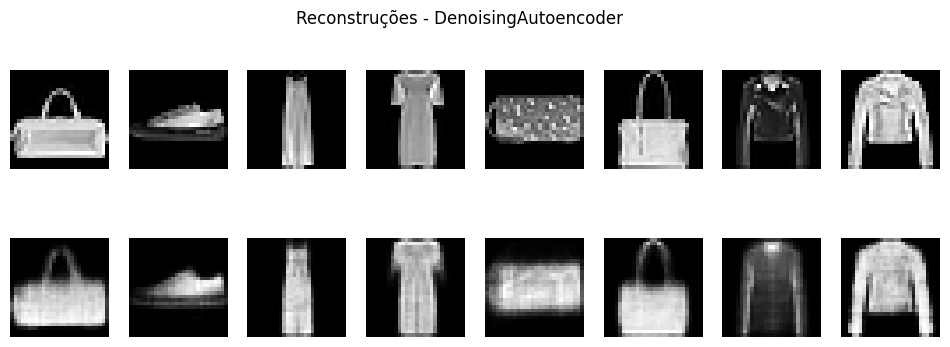

Reconstruções do VAE:


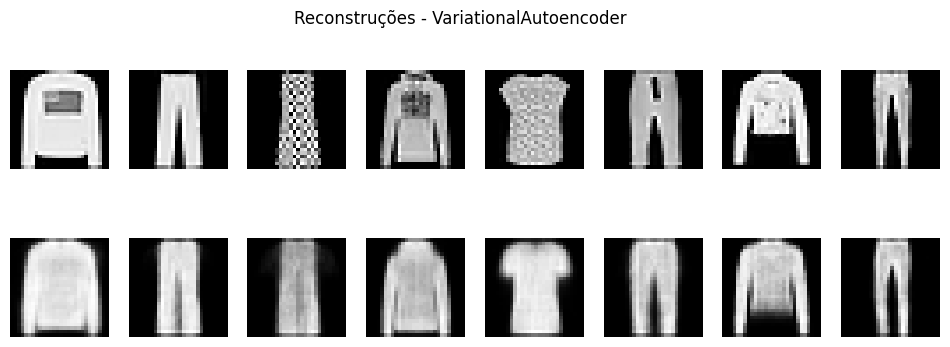

Amostras geradas pelo VAE:


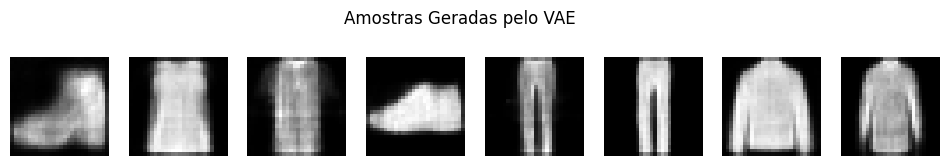

In [1]:
# %% [markdown]
# # EP4 - Comparação: AE, DAE e VAE
#
# Este código carrega o dataset Fashion MNIST e treina três arquiteturas:
# 1. Autoencoder Simples (AE)
# 2. Denoising Autoencoder (DAE)
# 3. Variational Autoencoder (VAE)
#
# Ele segue a mesma lógica de experimentação, permitindo comparações diretas.


# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Verifica se CUDA está disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# %% [markdown]
# ## Carregando o Dataset
#
# O mesmo dataset Fashion MNIST usado no exemplo do VAE.
# As imagens estão normalizadas em [-1,1].
# Dividimos em treino, validação e teste.

# %%
def carrega_dataset(validation_set_percent=0.1, batch_size=128, verbose=False):
    transform_list = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

    training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform_list)
    test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform_list)

    # Split train/val
    n_val = int(len(training_data)*validation_set_percent)
    n_train = len(training_data) - n_val
    train_set, val_set = random_split(training_data, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, pin_memory=True)

    if verbose:
        print("Dados carregados:")
        print(f"Train: {len(train_set)} samples")
        print(f"Val:   {len(val_set)} samples")
        print(f"Test:  {len(test_data)} samples")

        figure = plt.figure(figsize=(12, 3))
        plt.suptitle("Exemplos do Fashion MNIST")
        rows, cols = 2, 10
        for i in range(1, rows*cols+1):
            sample_idx = torch.randint(len(training_data), size=(1,)).item()
            img, label = training_data[sample_idx]
            figure.add_subplot(rows, cols, i)
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
        plt.show()

    return train_dataloader, val_dataloader, test_dataloader

train_dataloader, val_dataloader, test_dataloader = carrega_dataset(validation_set_percent=0.1, batch_size=256, verbose=True)

# %% [markdown]
# ## Funções de perda
#
# - AE/DAE: perda MSE simples.
# - VAE: perda composta por MSE + KLD.

# %%
def ae_loss(recons, input):
    return F.mse_loss(recons, input)

def vae_loss(recons, input, mu, log_var, kld_weight):
    recons_loss = F.mse_loss(recons, input)
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0)
    return recons_loss + kld_weight * kld_loss


# %% [markdown]
# ## Arquiteturas
#
# ### 1. Autoencoder Simples (AE)

# %%
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size=784, latent_dim=10):
        super(SimpleAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Tanh()
        )
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

# ### 2. Denoising Autoencoder (DAE)

# %%
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size=784, latent_dim=10):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

    def add_noise(self, x, noise_factor=0.3):
        x_noisy = x + noise_factor * torch.randn_like(x)
        x_noisy = torch.clip(x_noisy, -1.0, 1.0)
        return x_noisy

# ### 3. Variational Autoencoder (VAE)

# %%
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size=784):
        super(VariationalAutoencoder, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size,512)
        )
        self.fc21 = nn.Linear(512, 10) # mu
        self.fc22 = nn.Linear(512, 10) # log_var
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, input_size)

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def decode(self, z):
        z = self.relu(self.fc3(z))
        return torch.tanh(self.fc4(z))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        prediction = self.decode(z)
        return prediction, mu, logvar
    
    def sample(self, num_samples:int):
        z = torch.randn(num_samples, 10).to(device)
        samples = self.decode(z)
        return samples


# %% [markdown]
# ## Funções de Treinamento e Avaliação
#
# Reutilizaremos a lógica do VAE, adaptando para AE e DAE.

# %%
@torch.inference_mode()
def eval_loop_ae(dataloader, model, loss_fn, denoising=False):
    model.eval()
    eval_loss = 0
    num_batches = len(dataloader)

    for X, _ in dataloader:
        X = X.to(device)
        if denoising and hasattr(model, 'add_noise'):
            # Avaliação sem ruído
            recons = model(X)
        else:
            recons = model(X)
        X = X.view(-1, 784)
        loss = loss_fn(recons, X)
        eval_loss += loss.item()

    eval_loss /= num_batches
    return eval_loss

def train_loop_ae(dataloader, model, loss_fn, optimizer, denoising=False, noise_factor=0.3):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for X, _ in dataloader:
        X = X.to(device)

        if denoising and hasattr(model, 'add_noise'):
            X_noisy = model.add_noise(X, noise_factor=noise_factor)
            recons = model(X_noisy)
        else:
            recons = model(X)

        X = X.view(-1, 784)
        loss = loss_fn(recons, X)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    train_loss /= num_batches
    return train_loss

@torch.inference_mode()
def eval_loop_vae(dataloader, model, loss_fn):
    model.eval()
    eval_loss = 0
    num_batches = len(dataloader)

    for X, _ in dataloader:
        X = X.to(device)
        recons, mu, logvar = model(X)
        X = X.view(-1, 784)
        kld_weight = X.shape[0]/60000
        loss = loss_fn(recons, X, mu, logvar, kld_weight)
        eval_loss += loss.item()

    eval_loss /= num_batches
    return eval_loss

def train_loop_vae(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for X, _ in dataloader:
        X = X.to(device)
        recons, mu, logvar = model(X)
        X = X.view(-1, 784)
        kld_weight = X.shape[0]/60000
        loss = loss_fn(recons, X, mu, logvar, kld_weight)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    train_loss /= num_batches
    return train_loss


# %% [markdown]
# ## Treinando as Redes
#
# Treinaremos as três arquiteturas e compararemos suas perdas.

# %%
epochs = 10
lr = 3e-3

# AE
ae = SimpleAutoencoder().to(device)
optimizer_ae = torch.optim.AdamW(ae.parameters(), lr=lr)
print("Treinando AE...")
for t in range(epochs):
    train_loss = train_loop_ae(train_dataloader, ae, ae_loss, optimizer_ae, denoising=False)
    val_loss = eval_loop_ae(val_dataloader, ae, ae_loss, denoising=False)
    print(f"Epoch {t+1}/{epochs} AE: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

print("Treinamento do AE concluído!\n")

# DAE
dae = DenoisingAutoencoder().to(device)
optimizer_dae = torch.optim.AdamW(dae.parameters(), lr=lr)
print("Treinando DAE...")
for t in range(epochs):
    train_loss = train_loop_ae(train_dataloader, dae, ae_loss, optimizer_dae, denoising=True, noise_factor=0.3)
    val_loss = eval_loop_ae(val_dataloader, dae, ae_loss, denoising=False)
    print(f"Epoch {t+1}/{epochs} DAE: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

print("Treinamento do DAE concluído!\n")

# VAE
vae = VariationalAutoencoder().to(device)
optimizer_vae = torch.optim.AdamW(vae.parameters(), lr=3.5e-3)  # lr do exemplo original do VAE
print("Treinando VAE...")
for t in range(epochs):
    train_loss = train_loop_vae(train_dataloader, vae, vae_loss, optimizer_vae)
    val_loss = eval_loop_vae(val_dataloader, vae, vae_loss)
    print(f"Epoch {t+1}/{epochs} VAE: train_loss={train_loss:.3f}, val_loss={val_loss:.3f}")

print("Treinamento do VAE concluído!")


# %% [markdown]
# ## Visualização de Reconstruções
#
# Vamos inspecionar algumas reconstruções do conjunto de teste para verificar a qualidade dos três modelos.

# %%
@torch.inference_mode()
def plot_reconstructions(model, dataloader, num_images=8, denoising=False, noise_factor=0.3, vae=False):
    model.eval()
    for X, _ in dataloader:
        X = X.to(device)
        if denoising and hasattr(model, 'add_noise'):
            X_noisy = model.add_noise(X, noise_factor)
            recons = model(X_noisy) if not vae else model(X_noisy)[0]
        else:
            recons = model(X) if not vae else model(X)[0]
        break

    X = X[:num_images].detach().cpu()
    recons = recons[:num_images].detach().cpu().view(num_images, 1, 28, 28)

    figure = plt.figure(figsize=(12, 4))
    plt.suptitle(f"Reconstruções - {model.__class__.__name__}")
    for i in range(num_images):
        # Original
        ax = figure.add_subplot(2, num_images, i+1)
        ax.imshow(X[i].squeeze(), cmap='gray')
        ax.axis('off')

        # Reconstrução
        ax = figure.add_subplot(2, num_images, num_images + i + 1)
        ax.imshow(recons[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

print("Reconstruções do AE:")
plot_reconstructions(ae, test_dataloader, num_images=8, denoising=False)

print("Reconstruções do DAE (entrada limpa):")
plot_reconstructions(dae, test_dataloader, num_images=8, denoising=False)

print("Reconstruções do DAE (entrada ruidosa):")
plot_reconstructions(dae, test_dataloader, num_images=8, denoising=True, noise_factor=0.3)

print("Reconstruções do VAE:")
plot_reconstructions(vae, test_dataloader, num_images=8, denoising=False, vae=True)


# %% [markdown]
# ## Gerando Amostras do VAE
#
# O VAE pode gerar amostras a partir do espaço latente.

# %%
@torch.inference_mode()
def plot_vae_samples(model, num_samples=8):
    samples = model.sample(num_samples)
    samples = samples.detach().cpu().view(num_samples, 1, 28, 28)
    figure = plt.figure(figsize=(12, 2))
    plt.suptitle("Amostras Geradas pelo VAE")
    for i in range(num_samples):
        ax = figure.add_subplot(1, num_samples, i+1)
        ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

print("Amostras geradas pelo VAE:")
plot_vae_samples(vae, num_samples=8)
